# Simulation Study: Controlled Spatio-Temporal Data Generation (PeMS-like)

## Goal
We generate synthetic spatio-temporal data with **known ground-truth dynamics** so we can evaluate
whether different forecasting models exploit:
- **Temporal dependence** (autoregressive structure + seasonality)
- **Spatial dependence** (graph diffusion / neighbor influence)

We keep the *graph topology* and *timestamps* from the PeMS-derived dataset to preserve realism
(number of stations, time indexing, and sampling frequency), but we replace the observed flow/speed
with simulated signals.

## Key idea
We introduce a spatial coupling coefficient **α ∈ [0, 1]**:
- α = 0: stations evolve independently (no spatial structure)
- α > 0: stations interact via the road-network adjacency matrix (graph diffusion)

A good graph-based model should improve as α increases.

## Outputs
This notebook produces `.npz` files compatible with our training pipeline:
- X: (T, N, 6) with [flow, speed, hour_sin, hour_cos, dow_sin, dow_cos]
- Y: (T, N) flow target
- A, stations, timestamps, train/val/test starts, in_len, out_len
- flow_mean/std and speed_mean/std computed **using training indices only** (no leakage)


In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Paths (match your repo layout)
# ----------------------------
BASE = Path(".").resolve()
ART = BASE / "artifacts"
DATA_PATH_REAL = ART / "pems_graph_dataset_strict.npz"   # your existing dataset file
SIM_DIR = ART / "sim_datasets"
SIM_DIR.mkdir(parents=True, exist_ok=True)

print("BASE:", BASE)
print("DATA_PATH_REAL exists:", DATA_PATH_REAL.exists())
print("SIM_DIR:", SIM_DIR)

# ----------------------------
# Reproducibility
# ----------------------------
GLOBAL_SEED = 42
rng_global = np.random.default_rng(GLOBAL_SEED)


BASE: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience
DATA_PATH_REAL exists: True
SIM_DIR: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/sim_datasets


In [2]:
assert DATA_PATH_REAL.exists(), f"Missing file: {DATA_PATH_REAL}"

ds = np.load(DATA_PATH_REAL, allow_pickle=True)

A = ds["A"].astype(np.float32)              # (N,N)
stations = ds["stations"]                   # (N,)
timestamps = ds["timestamps"].astype("datetime64[ns]")  # (T,)

train_starts = ds["train_starts"].astype(np.int64)
val_starts   = ds["val_starts"].astype(np.int64)
test_starts  = ds["test_starts"].astype(np.int64)

IN_LEN  = int(np.array(ds["in_len"]).item())
OUT_LEN = int(np.array(ds["out_len"]).item())

T = len(timestamps)
N = A.shape[0]

print("A:", A.shape)
print("Timestamps:", T, "| range:", timestamps.min(), "->", timestamps.max())
print("Stations:", N)
print("IN_LEN:", IN_LEN, "OUT_LEN:", OUT_LEN)
print("train/val/test starts:", len(train_starts), len(val_starts), len(test_starts))


A: (1821, 1821)
Timestamps: 2208 | range: 2024-10-01T00:00:00.000000000 -> 2024-12-31T23:00:00.000000000
Stations: 1821
IN_LEN: 24 OUT_LEN: 72
train/val/test starts: 1009 289 673


In [3]:
def time_encoding(dt_index: pd.DatetimeIndex) -> np.ndarray:
    """Return (T,4): [hour_sin, hour_cos, dow_sin, dow_cos]."""
    hours = dt_index.hour.values
    dow   = dt_index.dayofweek.values
    hour_sin = np.sin(2*np.pi*hours/24.0)
    hour_cos = np.cos(2*np.pi*hours/24.0)
    dow_sin  = np.sin(2*np.pi*dow/7.0)
    dow_cos  = np.cos(2*np.pi*dow/7.0)
    return np.stack([hour_sin, hour_cos, dow_sin, dow_cos], axis=1).astype(np.float32)

dt_idx = pd.to_datetime(timestamps)
TF = time_encoding(dt_idx)  # (T,4)

print("TF:", TF.shape, "min/max:", float(TF.min()), float(TF.max()))


TF: (2208, 4) min/max: -1.0 1.0


In [4]:
def time_encoding(dt_index: pd.DatetimeIndex) -> np.ndarray:
    """Return (T,4): [hour_sin, hour_cos, dow_sin, dow_cos]."""
    hours = dt_index.hour.values
    dow   = dt_index.dayofweek.values
    hour_sin = np.sin(2*np.pi*hours/24.0)
    hour_cos = np.cos(2*np.pi*hours/24.0)
    dow_sin  = np.sin(2*np.pi*dow/7.0)
    dow_cos  = np.cos(2*np.pi*dow/7.0)
    return np.stack([hour_sin, hour_cos, dow_sin, dow_cos], axis=1).astype(np.float32)

dt_idx = pd.to_datetime(timestamps)
TF = time_encoding(dt_idx)  # (T,4)

print("TF:", TF.shape, "min/max:", float(TF.min()), float(TF.max()))


TF: (2208, 4) min/max: -1.0 1.0


In [5]:
def make_random_walk_matrix(A: np.ndarray, add_self_loops: bool = True) -> np.ndarray:
    """
    Build a row-normalized adjacency (random-walk matrix) for diffusion.
    Returns P where each row sums to 1 (approximately).
    """
    A = A.astype(np.float32)
    # symmetrize (undirected)
    A = np.maximum(A, A.T)

    if add_self_loops:
        A = A + np.eye(A.shape[0], dtype=np.float32)

    row_sum = A.sum(axis=1)
    row_sum = np.where(row_sum == 0, 1.0, row_sum)
    P = (A.T / row_sum).T
    return P.astype(np.float32)

P = make_random_walk_matrix(A, add_self_loops=True)

print("P:", P.shape)
print("Row sum check (first 5):", P.sum(axis=1)[:5])


P: (1821, 1821)
Row sum check (first 5): [1. 1. 1. 1. 1.]


In [7]:
def simulate_latent_process(
    P: np.ndarray,
    TF: np.ndarray,
    rho: float,
    alpha: float,
    noise_sigma: float,
    seed: int
) -> np.ndarray:
    """
    Simulate latent state z_t ∈ R^N with graph diffusion + seasonality:

        z_{t+1} = rho * z_t + alpha * (P z_t) + s(t) + eps_t
        z_{t+1} = tanh(z_{t+1})   # stabilizes dynamics

    where s(t) is node-specific daily/weekly seasonality built from TF.

    Returns
    -------
    z : (T,N) float32
    """
    rng = np.random.default_rng(seed)
    T = TF.shape[0]
    N = P.shape[0]

    # node-specific amplitudes (keeps stations heterogeneous)
    amp_daily  = rng.uniform(0.6, 1.6, size=N).astype(np.float32)
    amp_weekly = rng.uniform(0.2, 0.9, size=N).astype(np.float32)

    # Build seasonality from TF: hour_sin/cos + dow_sin/cos
    hour_sin, hour_cos, dow_sin, dow_cos = TF.T  # each is (T,)
    daily_signal  = (hour_sin + 0.5*hour_cos).astype(np.float32)
    weekly_signal = (dow_sin  + 0.5*dow_cos ).astype(np.float32)

    z = np.zeros((T, N), dtype=np.float32)
    z[0] = rng.normal(0, 1.0, size=N).astype(np.float32)

    for t in range(T - 1):
        spatial = P @ z[t]  # (N,)
        seasonal = 0.6 * daily_signal[t] * amp_daily + 0.4 * weekly_signal[t] * amp_weekly
        eps = rng.normal(0, noise_sigma, size=N).astype(np.float32)

        z_next = rho * z[t] + alpha * spatial + seasonal + eps
        z[t+1] = np.tanh(z_next)  # stabilizes + adds mild nonlinearity

    return z

def latent_to_flow_speed(z: np.ndarray, seed: int):
    """
    Map latent z_t to observable flow and speed.
    Flow is positive; speed decreases with flow (simple traffic-like relation).
    """
    rng = np.random.default_rng(seed + 10_000)
    T, N = z.shape

    # node-specific base demand + sensitivity
    base_flow  = rng.uniform(120, 420, size=N).astype(np.float32)
    scale_flow = rng.uniform(60, 160, size=N).astype(np.float32)

    flow = base_flow[None, :] + scale_flow[None, :] * z
    flow = np.clip(flow, 0.0, None).astype(np.float32)

    # speed roughly inversely related to flow
    vmax = 70.0
    k = rng.uniform(0.03, 0.08, size=N).astype(np.float32)  # how strongly flow reduces speed
    speed_noise = rng.normal(0, 2.0, size=(T, N)).astype(np.float32)

    speed = vmax - flow * k[None, :] + speed_noise
    speed = np.clip(speed, 0.0, vmax).astype(np.float32)

    return flow, speed


In [8]:
# ----------------------------
# Choose one scenario first
# ----------------------------
SIM_CONFIG = {
    "name": "sim_pems_like",
    "seed": 123,
    "rho": 0.70,          # temporal persistence
    "alpha": 0.30,        # spatial coupling strength (key experimental knob)
    "noise_sigma": 0.05,  # latent noise
}

z = simulate_latent_process(
    P=P,
    TF=TF,
    rho=SIM_CONFIG["rho"],
    alpha=SIM_CONFIG["alpha"],
    noise_sigma=SIM_CONFIG["noise_sigma"],
    seed=SIM_CONFIG["seed"],
)

flow, speed = latent_to_flow_speed(z, seed=SIM_CONFIG["seed"])

print("z:", z.shape, "flow:", flow.shape, "speed:", speed.shape)
print("flow stats:", float(flow.mean()), float(flow.std()), "min/max:", float(flow.min()), float(flow.max()))
print("speed stats:", float(speed.mean()), float(speed.std()), "min/max:", float(speed.min()), float(speed.max()))


z: (2208, 1821) flow: (2208, 1821) speed: (2208, 1821)
flow stats: 268.8896179199219 121.799072265625 min/max: 0.0 759.8511352539062
speed stats: 55.09693908691406 8.136998176574707 min/max: 16.539337158203125 70.0


In [9]:
# X: (T,N,6) with [flow, speed, hour_sin, hour_cos, dow_sin, dow_cos]
X = np.zeros((T, N, 6), dtype=np.float32)
X[:, :, 0] = flow
X[:, :, 1] = speed

# time features repeated across stations
X[:, :, 2] = TF[:, 0:1]  # hour_sin
X[:, :, 3] = TF[:, 1:1+1]  # hour_cos
X[:, :, 4] = TF[:, 2:2+1]  # dow_sin
X[:, :, 5] = TF[:, 3:3+1]  # dow_cos

# Y target: flow (T,N)
Y = flow.astype(np.float32)

print("X:", X.shape, "Y:", Y.shape)


X: (2208, 1821, 6) Y: (2208, 1821)


In [10]:
def compute_train_indices(train_starts, in_len, out_len):
    """
    Build the set of time indices touched by training samples (inputs + outputs),
    so scaling uses only training data.
    """
    train_starts = np.asarray(train_starts, dtype=np.int64)

    idx_in = train_starts[:, None] + np.arange(in_len)[None, :]
    idx_out = train_starts[:, None] + in_len + np.arange(out_len)[None, :]

    idx = np.unique(np.concatenate([idx_in.ravel(), idx_out.ravel()]))
    idx = idx[(idx >= 0) & (idx < T)]
    return idx

train_idx = compute_train_indices(train_starts, IN_LEN, OUT_LEN)
print("Unique training time indices:", len(train_idx), "of T=", T)

flow_train = flow[train_idx]    # (T_train,N)
speed_train = speed[train_idx]

flow_mean = flow_train.mean(axis=0).astype(np.float32)
flow_std  = flow_train.std(axis=0).astype(np.float32)
speed_mean = speed_train.mean(axis=0).astype(np.float32)
speed_std  = speed_train.std(axis=0).astype(np.float32)

# avoid tiny std
flow_std = np.maximum(flow_std, 1e-3)
speed_std = np.maximum(speed_std, 1e-3)

print("flow_mean/std:", flow_mean.shape, flow_std.shape)
print("speed_mean/std:", speed_mean.shape, speed_std.shape)


Unique training time indices: 1104 of T= 2208
flow_mean/std: (1821,) (1821,)
speed_mean/std: (1821,) (1821,)


In [12]:
sim_name = f"{SIM_CONFIG['name']}_alpha{SIM_CONFIG['alpha']:.2f}_seed{SIM_CONFIG['seed']}"
out_npz = SIM_DIR / f"{sim_name}.npz"
out_json = SIM_DIR / f"{sim_name}.json"

np.savez_compressed(
    out_npz,
    X=X,
    Y=Y,
    A=A,
    stations=stations,
    timestamps=timestamps,
    train_starts=train_starts,
    val_starts=val_starts,
    test_starts=test_starts,
    in_len=np.array(IN_LEN),
    out_len=np.array(OUT_LEN),
    flow_mean=flow_mean,
    flow_std=flow_std,
    speed_mean=speed_mean,
    speed_std=speed_std,
)

with open(out_json, "w", encoding="utf-8") as f:
    json.dump(SIM_CONFIG, f, indent=2)

print("Saved:", out_npz)
print("Saved config:", out_json)


Saved: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/sim_datasets/sim_pems_like_alpha0.30_seed123.npz
Saved config: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/sim_datasets/sim_pems_like_alpha0.30_seed123.json


In [13]:
sim_name = f"{SIM_CONFIG['name']}_alpha{SIM_CONFIG['alpha']:.2f}_seed{SIM_CONFIG['seed']}"
out_npz = SIM_DIR / f"{sim_name}.npz"
out_json = SIM_DIR / f"{sim_name}.json"

np.savez_compressed(
    out_npz,
    X=X,
    Y=Y,
    A=A,
    stations=stations,
    timestamps=timestamps,
    train_starts=train_starts,
    val_starts=val_starts,
    test_starts=test_starts,
    in_len=np.array(IN_LEN),
    out_len=np.array(OUT_LEN),
    flow_mean=flow_mean,
    flow_std=flow_std,
    speed_mean=speed_mean,
    speed_std=speed_std,
)

with open(out_json, "w", encoding="utf-8") as f:
    json.dump(SIM_CONFIG, f, indent=2)

print("Saved:", out_npz)
print("Saved config:", out_json)


Saved: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/sim_datasets/sim_pems_like_alpha0.30_seed123.npz
Saved config: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/sim_datasets/sim_pems_like_alpha0.30_seed123.json


## Generate multiple simulation datasets (α sweep × seeds)

We will generate a *family* of synthetic datasets by varying the **spatial coupling** parameter α.

We also vary the random seed to create multiple replications per α, enabling:
- error bars / confidence intervals,
- statistical comparisons,
- robustness claims.

We will also compute sanity metrics:
- **Mean edge correlation**: correlation between connected stations (should increase with α)
- **Mean temporal lag-1 autocorrelation**: should remain reasonably stable across α (mainly controlled by ρ)


In [14]:
import time

def compute_train_indices(train_starts, in_len, out_len, T):
    train_starts = np.asarray(train_starts, dtype=np.int64)
    idx_in  = train_starts[:, None] + np.arange(in_len)[None, :]
    idx_out = train_starts[:, None] + in_len + np.arange(out_len)[None, :]
    idx = np.unique(np.concatenate([idx_in.ravel(), idx_out.ravel()]))
    idx = idx[(idx >= 0) & (idx < T)]
    return idx

def make_XY(flow, speed, TF):
    """X: (T,N,6), Y: (T,N) with exact feature order used in the main project."""
    T = TF.shape[0]
    N = flow.shape[1]

    X = np.zeros((T, N, 6), dtype=np.float32)
    X[:, :, 0] = flow
    X[:, :, 1] = speed

    # time features broadcast across nodes
    X[:, :, 2] = TF[:, 0:1]  # hour_sin
    X[:, :, 3] = TF[:, 1:2]  # hour_cos
    X[:, :, 4] = TF[:, 2:3]  # dow_sin
    X[:, :, 5] = TF[:, 3:4]  # dow_cos

    Y = flow.astype(np.float32)  # target is flow
    return X, Y

def compute_scalers(flow, speed, train_idx):
    """Compute per-node means/stds using training indices only (no leakage)."""
    flow_train  = flow[train_idx]   # (T_train, N)
    speed_train = speed[train_idx]

    flow_mean = flow_train.mean(axis=0).astype(np.float32)
    flow_std  = flow_train.std(axis=0).astype(np.float32)
    speed_mean = speed_train.mean(axis=0).astype(np.float32)
    speed_std  = speed_train.std(axis=0).astype(np.float32)

    flow_std  = np.maximum(flow_std, 1e-3)
    speed_std = np.maximum(speed_std, 1e-3)

    return flow_mean, flow_std, speed_mean, speed_std

def generate_and_save_sim_dataset(
    name: str,
    alpha: float,
    seed: int,
    rho: float = 0.70,
    noise_sigma: float = 0.05,
):
    """
    Generate + save a simulation dataset compatible with the project pipeline.

    Returns: dict with paths and key stats.
    """
    t0 = time.time()

    config = {
        "name": name,
        "seed": int(seed),
        "rho": float(rho),
        "alpha": float(alpha),
        "noise_sigma": float(noise_sigma),
    }

    # simulate latent -> flow/speed
    z = simulate_latent_process(P=P, TF=TF, rho=rho, alpha=alpha, noise_sigma=noise_sigma, seed=seed)
    flow, speed = latent_to_flow_speed(z, seed=seed)

    # build X,Y
    X, Y = make_XY(flow, speed, TF)

    # compute scalers (train only)
    train_idx = compute_train_indices(train_starts, IN_LEN, OUT_LEN, T=len(TF))
    flow_mean, flow_std, speed_mean, speed_std = compute_scalers(flow, speed, train_idx)

    # save
    sim_name = f"{name}_alpha{alpha:.2f}_seed{seed}"
    out_npz  = SIM_DIR / f"{sim_name}.npz"
    out_json = SIM_DIR / f"{sim_name}.json"

    np.savez_compressed(
        out_npz,
        X=X,
        Y=Y,
        A=A,
        stations=stations,
        timestamps=timestamps,
        train_starts=train_starts,
        val_starts=val_starts,
        test_starts=test_starts,
        in_len=np.array(IN_LEN),
        out_len=np.array(OUT_LEN),
        flow_mean=flow_mean,
        flow_std=flow_std,
        speed_mean=speed_mean,
        speed_std=speed_std,
    )

    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(config, f, indent=2)

    dt = time.time() - t0

    return {
        "sim_name": sim_name,
        "alpha": alpha,
        "seed": seed,
        "rho": rho,
        "noise_sigma": noise_sigma,
        "npz_path": str(out_npz),
        "json_path": str(out_json),
        "flow_mean_global": float(flow.mean()),
        "flow_std_global": float(flow.std()),
        "speed_mean_global": float(speed.mean()),
        "speed_std_global": float(speed.std()),
        "seconds": dt,
    }


In [15]:
# ----------------------------
# Start small (debug grid)
# ----------------------------
ALPHAS = [0.0, 0.2, 0.4]       # debug first
SEEDS  = [0, 1]               # debug first

BASE_NAME = "sim_pems_like"
RHO = 0.70
NOISE = 0.05

records = []
for a in ALPHAS:
    for s in SEEDS:
        rec = generate_and_save_sim_dataset(
            name=BASE_NAME,
            alpha=a,
            seed=s,
            rho=RHO,
            noise_sigma=NOISE,
        )
        print("Saved:", rec["npz_path"])
        records.append(rec)

df_sim_index = pd.DataFrame(records)
sim_index_path = SIM_DIR / "sim_index_debug.csv"
df_sim_index.to_csv(sim_index_path, index=False)

df_sim_index


Saved: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/sim_datasets/sim_pems_like_alpha0.00_seed0.npz
Saved: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/sim_datasets/sim_pems_like_alpha0.00_seed1.npz
Saved: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/sim_datasets/sim_pems_like_alpha0.20_seed0.npz
Saved: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/sim_datasets/sim_pems_like_alpha0.20_seed1.npz
Saved: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/sim_datasets/sim_pems_like_alpha0.40_seed0.npz
Saved: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/sim_datasets/sim_pems_like_alpha0

,sim_name,alpha,seed,rho,noise_sigma,npz_path,json_path,flow_mean_global,flow_std_global,speed_mean_global,speed_std_global,seconds
0,sim_pems_like_alpha0.00_seed0,0.0,0,0.7,0.05,/notebooks/Spatio-Temporal-Prediction-and-Coor...,/notebooks/Spatio-Temporal-Prediction-and-Coor...,269.219543,116.010681,55.113285,7.886305,4.890544
1,sim_pems_like_alpha0.00_seed1,0.0,1,0.7,0.05,/notebooks/Spatio-Temporal-Prediction-and-Coor...,/notebooks/Spatio-Temporal-Prediction-and-Coor...,268.635132,116.868919,55.239239,7.968668,5.165414
2,sim_pems_like_alpha0.20_seed0,0.2,0,0.7,0.05,/notebooks/Spatio-Temporal-Prediction-and-Coor...,/notebooks/Spatio-Temporal-Prediction-and-Coor...,269.320435,119.625198,55.105461,8.053393,4.882647
3,sim_pems_like_alpha0.20_seed1,0.2,1,0.7,0.05,/notebooks/Spatio-Temporal-Prediction-and-Coor...,/notebooks/Spatio-Temporal-Prediction-and-Coor...,268.744476,120.425171,55.231033,8.135853,4.572034
4,sim_pems_like_alpha0.40_seed0,0.4,0,0.7,0.05,/notebooks/Spatio-Temporal-Prediction-and-Coor...,/notebooks/Spatio-Temporal-Prediction-and-Coor...,269.397064,122.318489,55.099316,8.178578,4.527884
5,sim_pems_like_alpha0.40_seed1,0.4,1,0.7,0.05,/notebooks/Spatio-Temporal-Prediction-and-Coor...,/notebooks/Spatio-Temporal-Prediction-and-Coor...,268.831055,123.056152,55.224518,8.260432,5.757656


In [16]:
# Build an edge list from A (sample edges for speed)
edges = np.argwhere(A > 0)
edges = edges[edges[:, 0] < edges[:, 1]]  # unique undirected edges
edges = edges[edges[:, 0] != edges[:, 1]] # remove diagonal if any

rng = np.random.default_rng(123)
num_edges = len(edges)
sample_k = min(2000, num_edges)
edge_sample = edges[rng.choice(num_edges, size=sample_k, replace=False)]

def mean_edge_corr(flow_2d: np.ndarray, edge_sample: np.ndarray) -> float:
    """
    flow_2d: (T,N)
    returns mean corr across sampled edges.
    """
    corrs = []
    for i, j in edge_sample:
        a = flow_2d[:, i]
        b = flow_2d[:, j]
        sa = a.std()
        sb = b.std()
        if sa < 1e-6 or sb < 1e-6:
            continue
        c = np.corrcoef(a, b)[0, 1]
        if np.isfinite(c):
            corrs.append(c)
    return float(np.mean(corrs)) if len(corrs) else float("nan")

def mean_lag1_autocorr(flow_2d: np.ndarray) -> float:
    """Average lag-1 autocorrelation across a random subset of nodes."""
    rng = np.random.default_rng(999)
    N = flow_2d.shape[1]
    nodes = rng.choice(N, size=min(200, N), replace=False)
    vals = []
    for n in nodes:
        x = flow_2d[:, n]
        x0 = x[:-1]
        x1 = x[1:]
        if x0.std() < 1e-6 or x1.std() < 1e-6:
            continue
        vals.append(np.corrcoef(x0, x1)[0, 1])
    return float(np.mean(vals)) if len(vals) else float("nan")

# Compute metrics for each dataset in the debug index
metrics = []
for _, row in df_sim_index.iterrows():
    data = np.load(row["npz_path"], allow_pickle=True)
    Y = data["Y"]  # (T,N) flow
    metrics.append({
        "alpha": float(row["alpha"]),
        "seed": int(row["seed"]),
        "edge_corr": mean_edge_corr(Y, edge_sample),
        "lag1": mean_lag1_autocorr(Y),
    })

df_metrics = pd.DataFrame(metrics)
df_metrics


,alpha,seed,edge_corr,lag1
0,0.0,0,0.968053,0.960732
1,0.0,1,0.968380,0.961055
2,0.2,0,0.970221,0.958567
3,0.2,1,0.971072,0.958899
4,0.4,0,0.964762,0.956348
5,0.4,1,0.966812,0.956751


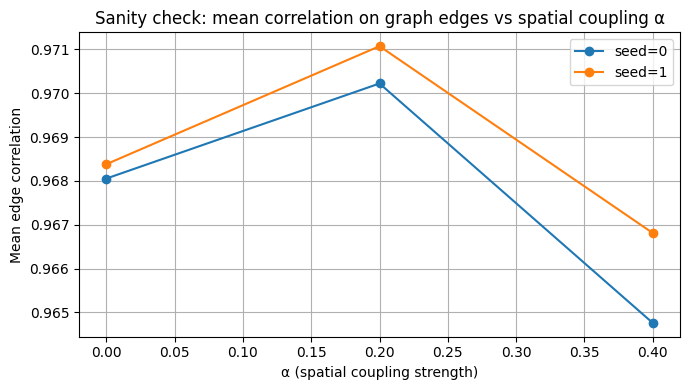

Saved figure: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/sim_datasets/sanity_edge_corr_vs_alpha.png


In [17]:
plt.figure(figsize=(7,4))
for seed, g in df_metrics.groupby("seed"):
    g2 = g.sort_values("alpha")
    plt.plot(g2["alpha"], g2["edge_corr"], marker="o", label=f"seed={seed}")

plt.title("Sanity check: mean correlation on graph edges vs spatial coupling α")
plt.xlabel("α (spatial coupling strength)")
plt.ylabel("Mean edge correlation")
plt.grid(True)
plt.legend()
plt.tight_layout()

out_fig = SIM_DIR / "sanity_edge_corr_vs_alpha.png"
plt.savefig(out_fig, dpi=300, bbox_inches="tight")
plt.show()

print("Saved figure:", out_fig)
